In [26]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor

from data_split import data_split_generator
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
import numpy as np
from tqdm import tqdm
from itertools import product
from matplotlib import pyplot as plt

In [2]:
[x for x in product(range(10), range(3))]

[(0, 0),
 (0, 1),
 (0, 2),
 (1, 0),
 (1, 1),
 (1, 2),
 (2, 0),
 (2, 1),
 (2, 2),
 (3, 0),
 (3, 1),
 (3, 2),
 (4, 0),
 (4, 1),
 (4, 2),
 (5, 0),
 (5, 1),
 (5, 2),
 (6, 0),
 (6, 1),
 (6, 2),
 (7, 0),
 (7, 1),
 (7, 2),
 (8, 0),
 (8, 1),
 (8, 2),
 (9, 0),
 (9, 1),
 (9, 2)]

In [3]:
def make_x_y(data: pd.DataFrame):
    data = data.copy(deep=True)
    data.reset_index(drop=True, inplace=True)
    # data['']
    data.drop(columns=['dates', 'target_dates'], inplace=True)
    # month = month_encoder.transform(data[['month']]).toarray()
    # month = pd.DataFrame(month, columns=[str(x) for x in month_encoder.categories_[0].tolist()])
    # data:pd.DataFrame = pd.concat([data, month], axis = 1)
    Y = data.pop('target_sunspots')
    return data , Y
def get_metric(y_true, y_predict):
    RMSE = np.sqrt(mean_squared_error(y_true, y_predict))
    # MAE = mean_absolute_error(y_true, y_predict)
    # MAPE = mean_absolute_percentage_error(y_true, y_predict)
    return RMSE

# train_x, train_y, month_encoder = make_x_y(train_data)
# train_x

In [4]:
final_metric = []
for j in tqdm(range(120, 133)):
    data = pd.read_csv(f'./data/pca_data_{j}.csv')
    data['target_dates'] = pd.to_datetime(data['target_dates'])
    n_estimators = range(40, 51, 5)
    max_depth = range(40, 51, 5)
    criterion = ['squared_error', 'absolute_error', 'friedman_mse', 'poisson']
    for n_estimators, max_depth, criterion in product(n_estimators, max_depth, criterion):
        metrics = []
        data_split = data_split_generator(data)
        for train_data, vali_data in data_split:
            train_x, train_y = make_x_y(train_data)
            rf = RandomForestRegressor(n_jobs=6, n_estimators=n_estimators, max_depth=max_depth, criterion=criterion)
            rf.fit(X=train_x, y=train_y)
            vali_x, vali_y = make_x_y(vali_data)
            predict = rf.predict(vali_x)
            metric = get_metric(vali_y, predict)
            metrics.append(metric)
        metrics = np.mean(metrics)
        final_metric.append([j, n_estimators, max_depth, criterion, metrics])

final_metric = pd.DataFrame(final_metric, columns=['m', 'n_estimators', 'max_depth', 'criterion', 'metrics'])
final_metric

100%|██████████| 13/13 [02:12<00:00, 10.20s/it]


,m,n_estimators,max_depth,criterion,metrics
0,120,40,40,squared_error,40.769902
1,120,40,40,absolute_error,40.721698
2,120,40,40,friedman_mse,40.701735
3,120,40,40,poisson,42.193267
4,120,40,45,squared_error,41.150509
...,...,...,...,...,...
463,132,50,45,poisson,41.469181
464,132,50,50,squared_error,40.984890
465,132,50,50,absolute_error,41.381113
466,132,50,50,friedman_mse,40.746174


In [5]:
final_metric[final_metric.m == 120].groupby('max_depth').mean()

/var/folders/ph/g14_8mqx0kb1gfr_kzfhtfvr0000gn/T/ipykernel_42481/3729959501.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  final_metric[final_metric.m == 120].groupby('max_depth').mean()


,m,n_estimators,metrics
max_depth,,,
40,120.0,45.0,41.101521
45,120.0,45.0,41.015768
50,120.0,45.0,41.018485


In [6]:
final_metric["rank"] = final_metric.groupby(['m'])['metrics'].rank(method="dense", ascending=True)
grid_search_result = final_metric[final_metric['rank'] == 1.0]
grid_search_result

,m,n_estimators,max_depth,criterion,metrics,rank
16,120,45,45,squared_error,40.076297,1.0
61,121,50,40,absolute_error,40.552609,1.0
90,122,45,45,friedman_mse,39.362040,1.0
108,123,40,40,squared_error,42.498986,1.0
178,124,50,50,friedman_mse,40.898416,1.0
197,125,45,45,absolute_error,40.634873,1.0
228,126,45,40,squared_error,39.649298,1.0
253,127,40,40,absolute_error,39.427864,1.0
289,128,40,40,absolute_error,38.605136,1.0
330,129,40,45,friedman_mse,39.083790,1.0


In [10]:
hypter_params = grid_search_result[grid_search_result.m == 120]
m, n_estimators, max_depth, criterion, metrics, rank = hypter_params.values[0]
m, n_estimators, max_depth, criterion, metrics, rank

(120, 45, 45, 'squared_error', 40.07629689443901, 1.0)

In [15]:
def split_data(data):
    train_end_date = pd.to_datetime('1963-12-31')
    vali_end_date = pd.to_datetime('1973-12-31')
    test_end_date = pd.to_datetime('1983-12-31')
    train_start_date = train_end_date + pd.DateOffset(years=-30) + pd.offsets.MonthEnd(0)
    train_data = data[(data.target_dates >= train_start_date) & (data.target_dates <= train_end_date)]
    vali_data = data[(data.target_dates > train_end_date) & (data.target_dates <= vali_end_date)]
    test_data = data[(data.target_dates > vali_end_date) & (data.target_dates <= test_end_date)]
    return train_data, vali_data, test_data
train_data, vali_data, test_data = split_data(data)
train_data

,x1,x2,x3,dates,target_dates,target_sunspots
2051,-132.264591,-71.152028,-8.550642,1922-12-31,1933-12-31,0.3
2052,-134.426993,-74.662940,1.301216,1923-01-31,1934-01-31,3.4
2053,-135.435246,-75.441004,5.179604,1923-02-28,1934-02-28,7.8
2054,-131.083245,-78.307501,21.027288,1923-03-31,1934-03-31,4.3
2055,-145.642574,-70.603453,-19.849659,1923-04-30,1934-04-30,11.3
...,...,...,...,...,...,...
2407,-12.353115,-107.334913,68.876294,1952-08-31,1963-08-31,33.2
2408,-12.174711,-107.632454,69.363180,1952-09-30,1963-09-30,38.8
2409,-22.364940,-106.847142,61.820041,1952-10-31,1963-10-31,35.3
2410,-29.216788,-109.061341,69.238278,1952-11-30,1963-11-30,23.4


In [23]:
results = []
for j in tqdm(range(120, 133)):
    data = pd.read_csv(f'./data/pca_data_{j}.csv')
    data['target_dates'] = pd.to_datetime(data['target_dates'])
    hypter_params = grid_search_result[grid_search_result.m == j]
    m, n_estimators, max_depth, criterion, metrics, rank = hypter_params.values[0]
    metrics = []
    data_split = data_split_generator(data)
    train_data, vali_data = next(data_split)
    train_data, vali_data, test_data = split_data(data)
    rf = RandomForestRegressor(n_jobs=6, n_estimators=n_estimators, max_depth=max_depth, criterion=criterion)
    rf.fit(X=train_x, y=train_y)
    predict = rf.predict(train_x)
    train_data['predict'] = predict
    train_data = train_data[['dates', 'target_dates', 'target_sunspots', 'predict']].copy(deep=True)
    train_data['type'] = 'train'
    train_data['m'] = j
    results.append(train_data)
    vali_x, vali_y = make_x_y(vali_data)
    predict = rf.predict(vali_x)
    vali_data['predict'] = predict
    vali_data = vali_data[['dates', 'target_dates', 'target_sunspots', 'predict']].copy(deep=True)
    vali_data['type'] = 'vali'
    vali_data['m'] = j
    results.append(vali_data)
    test_x, test_y = make_x_y(test_data)
    predict = rf.predict(test_x)
    test_data['predict'] = predict
    test_data = test_data[['dates', 'target_dates', 'target_sunspots', 'predict']].copy(deep=True)
    test_data['type'] = 'test'
    test_data['m'] = j
    results.append(test_data)

results = pd.concat(results)
results

  0%|          | 0/13 [00:00<?, ?it/s]/var/folders/ph/g14_8mqx0kb1gfr_kzfhtfvr0000gn/T/ipykernel_42481/3181165686.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['predict'] = predict
/var/folders/ph/g14_8mqx0kb1gfr_kzfhtfvr0000gn/T/ipykernel_42481/3181165686.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  vali_data['predict'] = predict
/var/folders/ph/g14_8mqx0kb1gfr_kzfhtfvr0000gn/T/ipykernel_42481/3181165686.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

,dates,target_dates,target_sunspots,predict,type,m
2063,1923-12-31,1933-12-31,0.3,87.940000,train,120
2064,1924-01-31,1934-01-31,3.4,82.593333,train,120
2065,1924-02-29,1934-02-28,7.8,81.435556,train,120
2066,1924-03-31,1934-03-31,4.3,60.137778,train,120
2067,1924-04-30,1934-04-30,11.3,80.624444,train,120
...,...,...,...,...,...,...
2647,1972-08-31,1983-08-31,71.8,76.740000,test,132
2648,1972-09-30,1983-09-30,50.3,75.655556,test,132
2649,1972-10-31,1983-10-31,55.8,76.733333,test,132
2650,1972-11-30,1983-11-30,33.3,75.751111,test,132


120


<Figure size 1000x500 with 0 Axes>

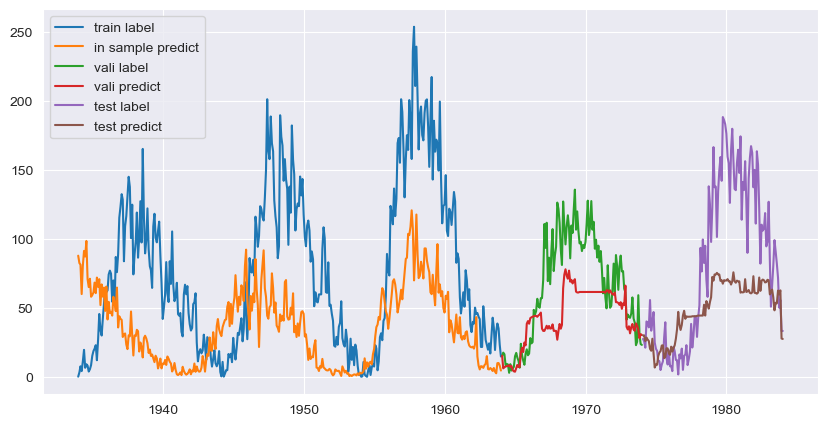

121


<Figure size 1000x500 with 0 Axes>

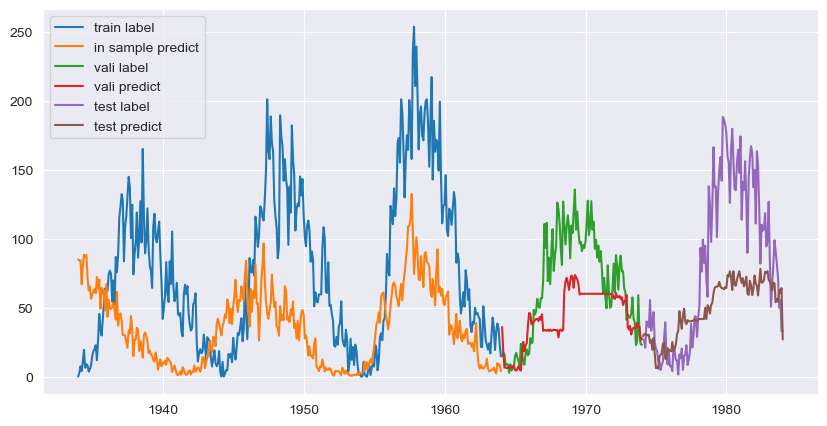

122


<Figure size 1000x500 with 0 Axes>

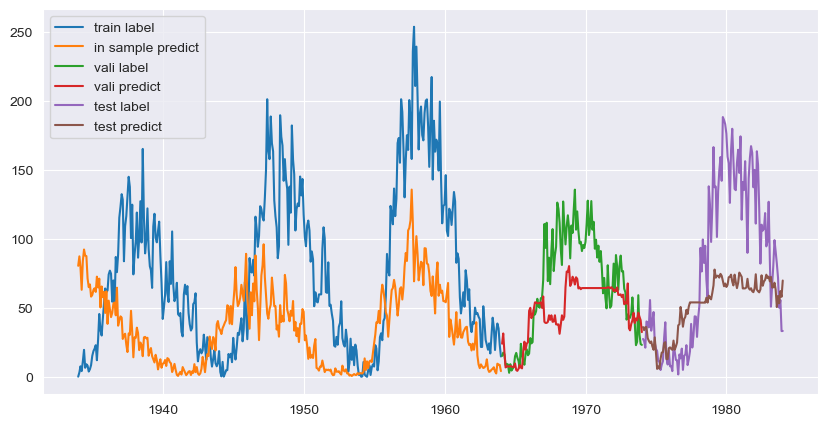

123


<Figure size 1000x500 with 0 Axes>

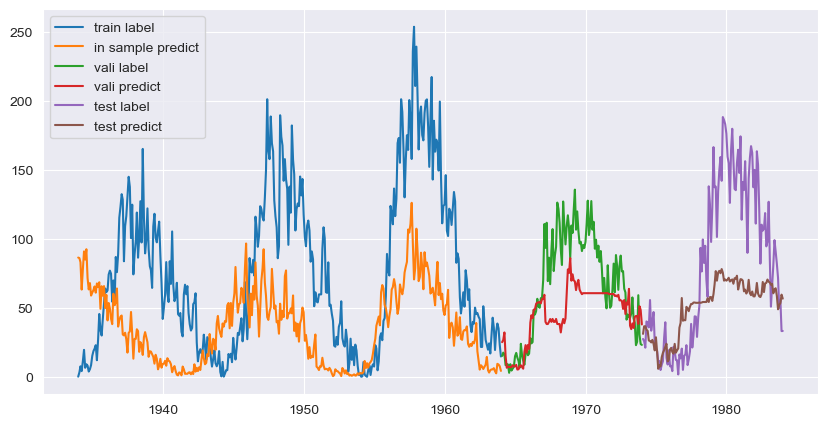

124


<Figure size 1000x500 with 0 Axes>

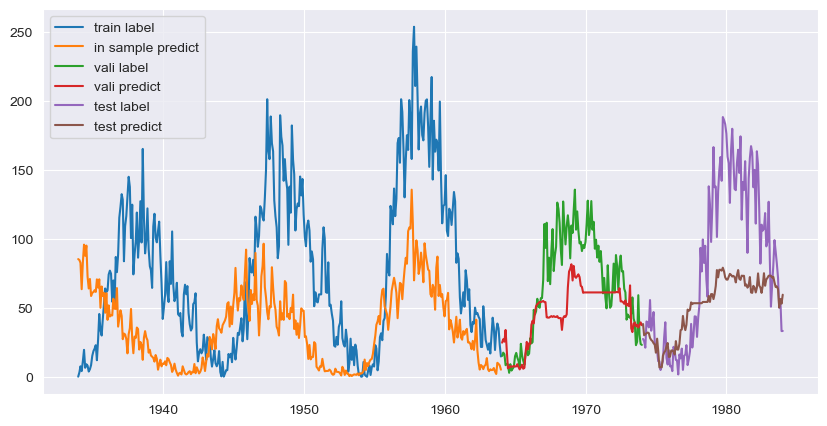

125


<Figure size 1000x500 with 0 Axes>

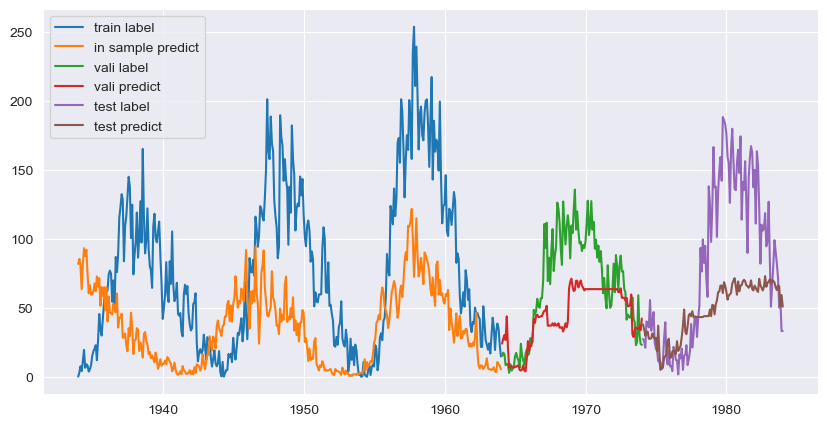

126


<Figure size 1000x500 with 0 Axes>

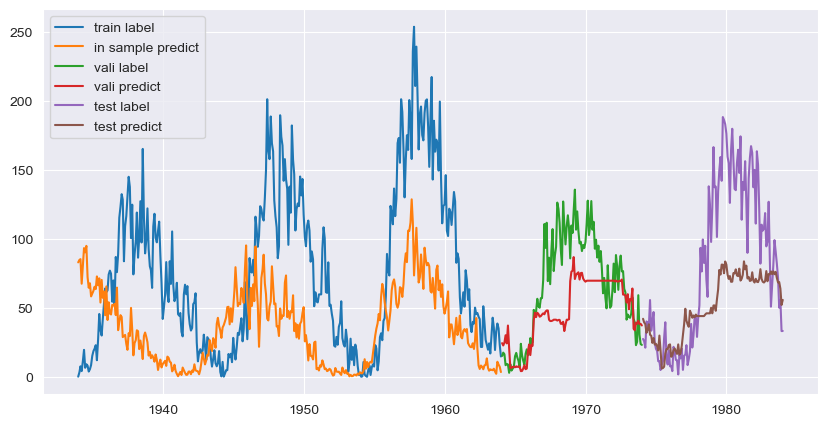

127


<Figure size 1000x500 with 0 Axes>

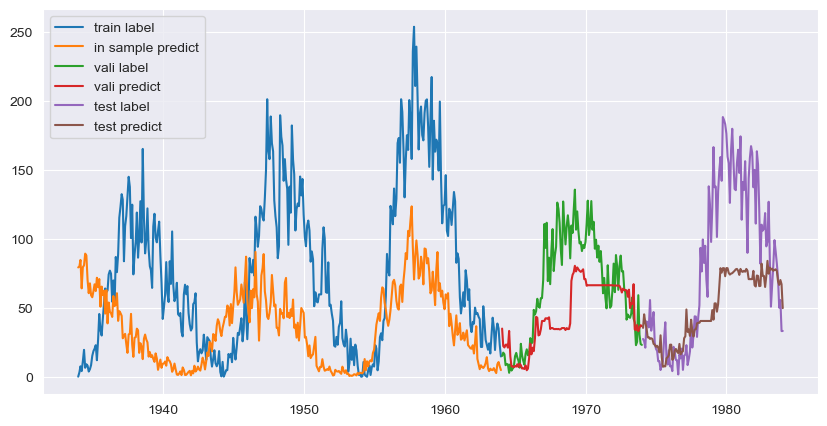

128


<Figure size 1000x500 with 0 Axes>

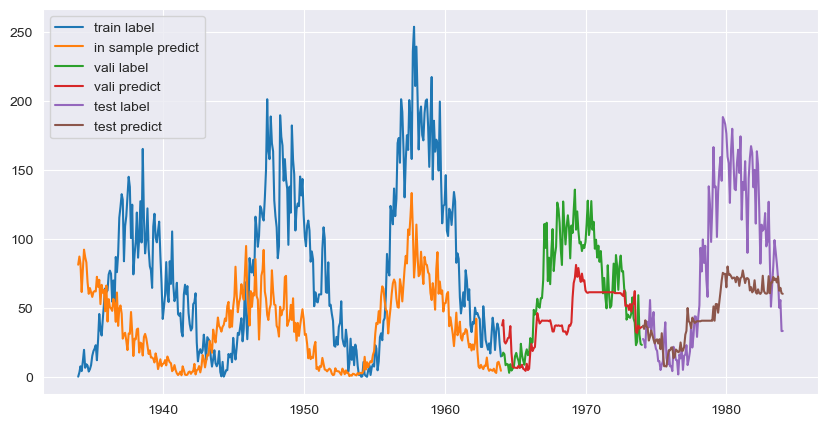

129


<Figure size 1000x500 with 0 Axes>

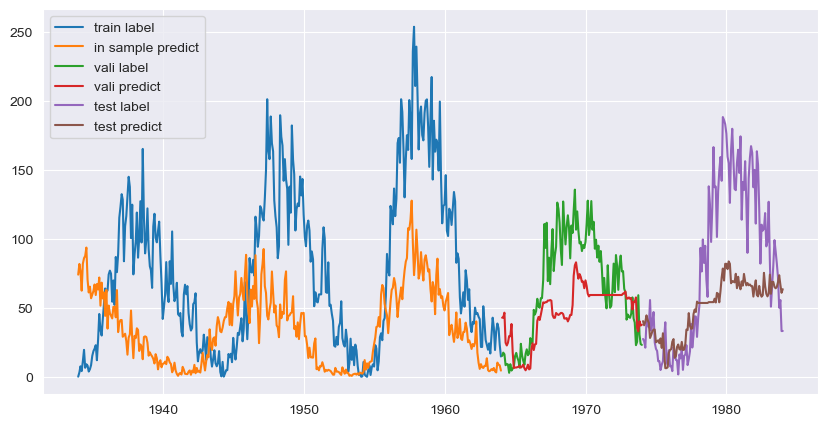

130


<Figure size 1000x500 with 0 Axes>

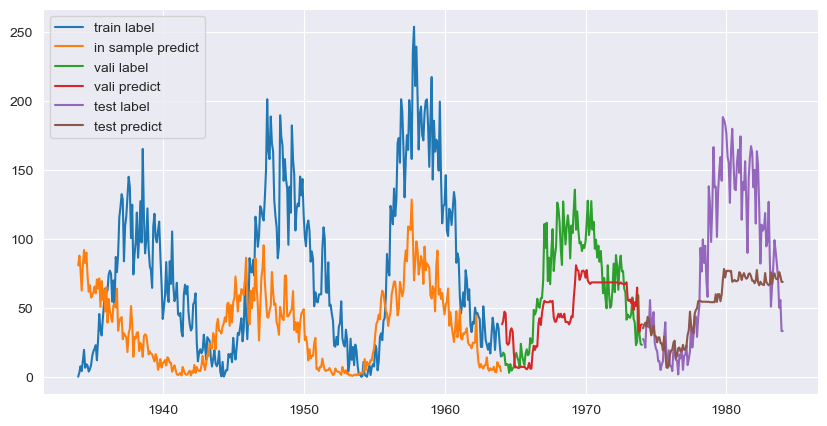

131


<Figure size 1000x500 with 0 Axes>

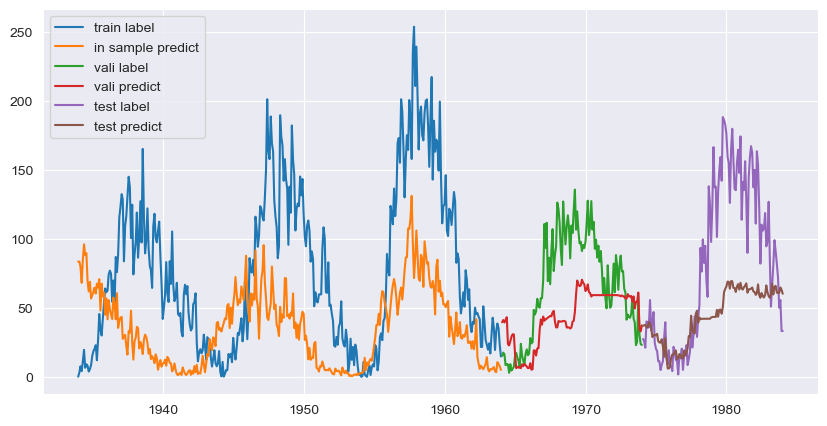

132


<Figure size 1000x500 with 0 Axes>

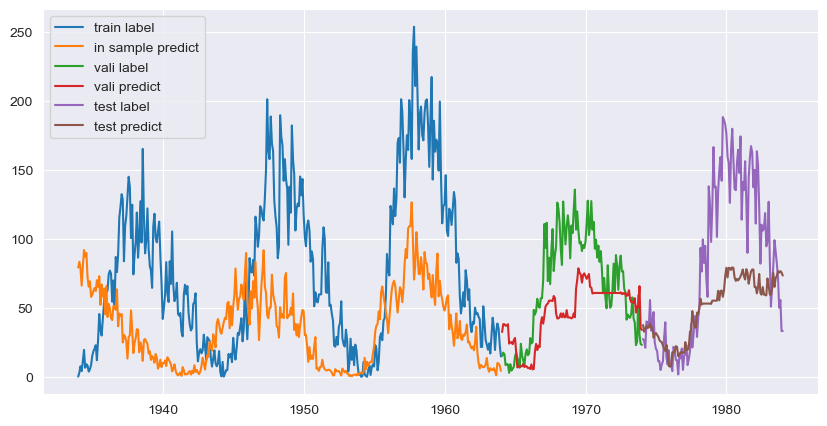

In [37]:
for m, single_result in results.groupby('m'):
    single_result['target_dates'] = pd.to_datetime(single_result['target_dates'])
    print(m)
    plt.clf()
    plt.figure(figsize=(10, 5))
    plt.plot(single_result[single_result.type == 'train'].target_dates, single_result[single_result.type == 'train'].target_sunspots,label='train label') # train
    plt.plot(single_result[single_result.type == 'train'].target_dates, single_result[single_result.type == 'train'].predict,label='in sample predict') # test
    plt.plot(single_result[single_result.type == 'vali'].target_dates, single_result[single_result.type == 'vali'].target_sunspots,label='vali label') # train
    plt.plot(single_result[single_result.type == 'vali'].target_dates, single_result[single_result.type == 'vali'].predict,label='vali predict') # test
    plt.plot(single_result[single_result.type == 'test'].target_dates, single_result[single_result.type == 'test'].target_sunspots,label='test label') # train
    plt.plot(single_result[single_result.type == 'test'].target_dates, single_result[single_result.type == 'test'].predict,label='test predict') # test
    # ax.plot(series.iloc[1:N+1].index,model_fit.predict(start=1,end=N,dynamic=False,typ='levels'),
    #         color='orange',label='in sample predict') # in-sample
    # ax.plot(fc_series, label='forecast', color='red') # forecast
    # ax.fill_between(series.iloc[N:].index, lower_series, upper_series, color='k', alpha=.15) # conf
    plt.legend(loc='upper left')
    plt.show()